In [2]:
! pip install python-mnist

In [32]:
! pip install scikit-image

In [77]:
! pip install imgaug

     |████████████████████████████████| 948 kB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 28.2 MB 28.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 51.2 MB/s eta 0:00:01


In [15]:
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
torch.manual_seed(1)
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader 
import os

In [3]:
torch.cuda.set_device(0)

In [4]:
torch.cuda.current_device()

0

In [5]:
from mnist import MNIST
import numpy as np
mndata = MNIST('Data/MNIST')
X_train, y_train = mndata.load_training()
X_train = np.array(X_train).reshape(60000,28,28)
y_train = np.array(y_train)

In [6]:
X_test, y_test = mndata.load_testing()
X_test = np.array(X_test).reshape(10000,28,28)
y_test = np.array(y_test)

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
from skimage.metrics import structural_similarity as ssim

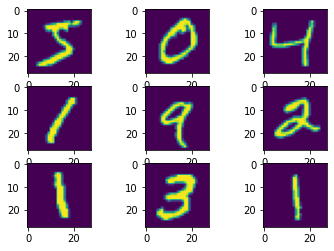

In [9]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
plt.show()

In [10]:
ssim(X_train[0], X_train[3], data_range=255)

0.19064748123354602

In [11]:
np.bincount(np.array(y_train))

array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from collections import OrderedDict
from torch.optim import Adam, SGD
from torch.autograd import Variable


In [13]:
pre_X = X_train
X_train = np.zeros(shape=(60000,28,28,3))
for i in range(X_train.shape[0]):
    img = np.stack((pre_X[i],)*3, axis=-1)
    X_train[i] = img/255
del pre_X

In [14]:
pre_X_test = X_test
X_test = np.zeros(shape=(10000,28,28,3))
for i in range(X_test.shape[0]):
    img = np.stack((pre_X_test[i],)*3, axis=-1)
    X_test[i] = img/255
del pre_X_test

In [70]:
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = torch.nn.Conv2d(3, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False)

In [71]:
def calculate_metric(metric_fn, true_y, pred_y):
    # multi class problems need to have averaging method
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    

In [72]:
def train_res(epoch):
    total_loss = 0

    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # ----------------- VALIDATION  ----------------- 
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)

            outputs = model(X) # this get's the prediction from the network

            val_losses += criterion(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
          
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches) # for plotting learning curve
    

In [73]:
def print_scores(p, r, f1, a, batch_size):
    # just an utility printing function
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [74]:
from sklearn.model_selection import train_test_split
def make_data_loaders(X_train, y_train, batch_size):
    X_train = X_train.reshape(X_train.shape[0],3,28,28)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)
    data_transform = Compose([Resize((224, 224))])
    X_train = torch.from_numpy(X_train).type(torch.float)
    y_train = torch.from_numpy(y_train).type(torch.LongTensor)

    X_val = torch.from_numpy(X_val).type(torch.float)
    y_val = torch.from_numpy(y_val).type(torch.LongTensor)

    train_d = torch.utils.data.TensorDataset(X_train,y_train)
    train_loader = torch.utils.data.DataLoader(train_d, batch_size = batch_size, shuffle = False)

    val_d = torch.utils.data.TensorDataset(X_val,y_val)
    val_loader = torch.utils.data.DataLoader(val_d,batch_size = batch_size, shuffle = False)
    return train_loader, val_loader

In [75]:
batch_size = 100

X_test = X_test.reshape(X_test.shape[0],3,28,28)
X_test = torch.from_numpy(X_test).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)
test_d = torch.utils.data.TensorDataset(X_test,y_test)
test_loader = torch.utils.data.DataLoader(test_d, batch_size = batch_size, shuffle = False)

In [76]:
train_loader, val_loader = make_data_loaders(X_train, y_train, batch_size)

In [21]:
# model:
model = MnistResNet()

epochs = 5
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start_ts = time.time()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    train_res(epoch)
    
print(f"Training time: {time.time()-start_ts}s")


Epoch 1/5, training loss: 0.7623129600617621, validation loss: 0.2254086136817932
	     precision: 0.9313
	        recall: 0.9308
	            F1: 0.9267
	      accuracy: 0.9313



Epoch 2/5, training loss: 0.19843277005271778, validation loss: 0.18308965861797333
	     precision: 0.9444
	        recall: 0.9440
	            F1: 0.9406
	      accuracy: 0.9443



Epoch 3/5, training loss: 0.14898072246048186, validation loss: 0.15183039009571075
	     precision: 0.9569
	        recall: 0.9561
	            F1: 0.9539
	      accuracy: 0.9571



Epoch 4/5, training loss: 0.16008506768693526, validation loss: 0.13351550698280334
	     precision: 0.9594
	        recall: 0.9594
	            F1: 0.9568
	      accuracy: 0.9598



Epoch 5/5, training loss: 0.1095812642801967, validation loss: 0.13476109504699707
	     precision: 0.9611
	        recall: 0.9605
	            F1: 0.9585
	      accuracy: 0.9609
Training time: 609.9581949710846s


In [96]:
def compute_test(model, test_loader, c):
    class_correct = 0
    class_total = 0
    model.eval()
    test_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            X, y = data[0].to(device), data[1].to(device)

            outputs = model(X) # this get's the prediction from the network

            test_losses += criterion(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction

            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                    (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
            class_correct += np.sum((predicted_classes.cpu().data.numpy() == c) & (y.cpu().data.numpy() == c))
            class_total += np.sum(y.cpu().data.numpy() == c)
            
            
    print(f"test loss: {test_losses/len(test_loader)}")
    print_scores(precision, recall, f1, accuracy, batch_size)
    print(f"accuracy for class {c}: {class_correct/class_total}")

In [23]:
compute_test(model, test_loader, 4)

test loss: 0.12828829884529114
	     precision: 0.9638
	        recall: 0.9631
	            F1: 0.9606
	      accuracy: 0.9636
accuracy for class 4: 0.9765784114052953


## Data Augmentation

Simulate images for imbalanced classes

In [77]:
from config import get_arguments
from SinGAN.manipulate import *
from SinGAN.training import *
import SinGAN.functions as functions

In [78]:
imb_class_list = np.random.randint(low=0, high=10, size=2)

In [79]:
c = 4

In [80]:
class_indices = np.where(y_train == c)[0]

In [81]:
class_indices.shape

(5842,)

In [82]:
to_replace = np.random.choice(class_indices, int(0.975*class_indices.size), replace=False)

In [83]:
left = np.setdiff1d(class_indices, to_replace)

In [84]:
len(left)

147

Calculate SSIM

In [99]:
def av_SSIM(images, other=None, pairs=100):
    l = np.zeros(pairs)
    if other:
        ind_a = np.random.choice(list(range(images.shape[0])), size = pairs)
        ind_b = np.random.choice(list(range(other.shape[0])), size = pairs)
    else:
        ind_a = np.random.choice(list(range(images.shape[0])), size = pairs)
        ind_b = np.zeros(pairs, dtype=int)
        count = 0
        while count < pairs:
            ind_b[count] = np.random.choice(list(range(images.shape[0])), size = 1)[0]
            if ind_a[count] != ind_b[count]:
                count += 1
    
    for i in range(pairs):
        if other:
            l[i] = ssim(images[ind_a[i]], other[ind_b[i]], data_range=1, multichannel=True)
        else:
            l[i] = ssim(images[ind_a[i]], images[ind_b[i]], data_range=1, multichannel=True)
    
    return l.mean()
              

In [100]:
av_SSIM(X_train[y_train==c])

0.27729570652762636

### Train with imbalanced data

In [86]:
# Data used in training SinGAN 

from PIL import Image

input_dir = 'input/'
input_paths = list(filter(lambda x : x.startswith('MNIST_4'), os.listdir(input_dir)))
train_left = np.zeros(shape=(len(left), 28, 28, 3))
count = 0
for path in input_paths:
    im = Image.open(input_dir+path)
    im = np.array(im)
    if im.shape != (28,28,3):
        im = im[:,:,:-1]
    train_left[count] = im/255
    count += 1
    if count == len(left): break

In [144]:
X_aug = X_train.copy()
y_aug = y_train.copy()
X_aug[left] = train_left
X_aug = np.delete(X_aug, to_replace, axis=0)
y_aug = np.delete(y_aug,to_replace, axis=0)

In [145]:
# model:
batch_size = 100
train_loader, val_loader = make_data_loaders(X_aug, y_aug, batch_size)
model = MnistResNet()

epochs = 5
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start_ts = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    train_res(epoch)
    
print(f"Training time: {time.time()-start_ts}s")


Epoch 1/5, training loss: 0.7921032045657436, validation loss: 0.36165350675582886
	     precision: 0.8734
	        recall: 0.8684
	            F1: 0.8621
	      accuracy: 0.8887



Epoch 2/5, training loss: 0.21875545183452322, validation loss: 0.18343882262706757
	     precision: 0.9345
	        recall: 0.9315
	            F1: 0.9298
	      accuracy: 0.9459



Epoch 3/5, training loss: 0.1619335678679978, validation loss: 0.14881697297096252
	     precision: 0.9451
	        recall: 0.9433
	            F1: 0.9417
	      accuracy: 0.9561



Epoch 4/5, training loss: 0.1275741153364709, validation loss: 0.2150912880897522
	     precision: 0.9238
	        recall: 0.9211
	            F1: 0.9180
	      accuracy: 0.9344



Epoch 5/5, training loss: 0.11530463092083879, validation loss: 0.14195935428142548
	     precision: 0.9483
	        recall: 0.9482
	            F1: 0.9454
	      accuracy: 0.9576
Training time: 554.4538049697876s


In [146]:
compute_test(model, test_loader, c)

test loss: 0.2604498565196991
	     precision: 0.9385
	        recall: 0.9317
	            F1: 0.9268
	      accuracy: 0.9318
accuracy for class 4: 0.6792260692464358


### Train with baseline data augmentation

In [149]:
from imgaug import augmenters as iaa
import imgaug as ia
ia.seed(42)
seq = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) 

In [150]:
X_aug = X_train.copy()
y_aug = y_train.copy()
X_aug[left] = train_left
for i in range(to_replace.size):
    X_aug[to_replace[i]] = seq(image = X_aug[left][i % left.size])

In [155]:
# model:
batch_size = 100
train_loader, val_loader = make_data_loaders(X_aug, y_aug, batch_size)
model = MnistResNet()

epochs = 5
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start_ts = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    train_res(epoch)
    
print(f"Training time: {time.time()-start_ts}s")


Epoch 1/5, training loss: 1.1531706913312276, validation loss: 2.983776569366455
	     precision: 0.7376
	        recall: 0.5674
	            F1: 0.5700
	      accuracy: 0.5685



Epoch 2/5, training loss: 0.22828959193494586, validation loss: 0.20512036979198456
	     precision: 0.9398
	        recall: 0.9362
	            F1: 0.9338
	      accuracy: 0.9379



Epoch 3/5, training loss: 0.1526052852223317, validation loss: 0.154665008187294
	     precision: 0.9551
	        recall: 0.9543
	            F1: 0.9518
	      accuracy: 0.9552



Epoch 4/5, training loss: 0.13902515972240104, validation loss: 0.23399457335472107
	     precision: 0.9345
	        recall: 0.9300
	            F1: 0.9271
	      accuracy: 0.9313



Epoch 5/5, training loss: 0.12438803477005826, validation loss: 0.14013080298900604
	     precision: 0.9615
	        recall: 0.9594
	            F1: 0.9578
	      accuracy: 0.9609
Training time: 608.8643999099731s


In [156]:
compute_test(model, test_loader,c)

test loss: 0.21961607038974762
	     precision: 0.9418
	        recall: 0.9331
	            F1: 0.9309
	      accuracy: 0.9342
accuracy for class 4: 0.7423625254582484


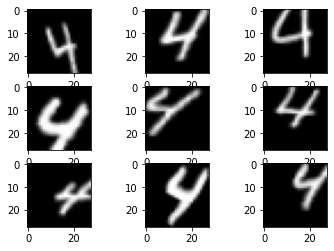

In [108]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_aug[to_replace[i]])
plt.show()

### Train with SinGAN

In [33]:
import MNIST_SinGAN

In [ ]:
torch.cuda.set_device(0)
start_ts = time.time()
simulated_imgs = MNIST_SinGAN.generate_data(class_label = c, generate_size = to_replace.size, sample_size=147)
print(time.time()-start_ts)
simulated_imgs = np.array(simulated_imgs[:to_replace.size])

In [51]:
torch.cuda.set_device(1)

In [35]:
simulated_imgs.shape

(5842, 28, 28, 3)

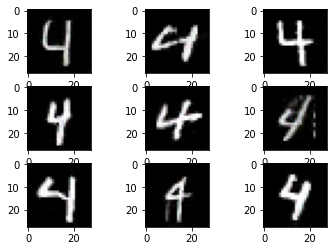

In [36]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(simulated_imgs[i])
plt.show()

In [37]:
av_SSIM(simulated_imgs)

0.2825011128378561

In [38]:
X_aug = X_train.copy()
y_aug = y_train.copy()
X_aug[to_replace] = simulated_imgs

In [39]:
# model:
batch_size = 100
train_loader, val_loader = make_data_loaders(X_aug, y_aug, batch_size)
model = MnistResNet()

epochs = 5
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start_ts = time.time()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    train_res(epoch)
    
print(f"Training time: {time.time()-start_ts}s")


Epoch 1/5, training loss: 0.6945212119486597, validation loss: 0.26198825240135193
	     precision: 0.9239
	        recall: 0.9207
	            F1: 0.9166
	      accuracy: 0.9225



Epoch 2/5, training loss: 0.21329288051360185, validation loss: 0.21405856311321259
	     precision: 0.9390
	        recall: 0.9349
	            F1: 0.9316
	      accuracy: 0.9361



Epoch 3/5, training loss: 0.15481537414507734, validation loss: 0.1473848521709442
	     precision: 0.9577
	        recall: 0.9561
	            F1: 0.9539
	      accuracy: 0.9569



Epoch 4/5, training loss: 0.1091973528245257, validation loss: 0.13463997840881348
	     precision: 0.9623
	        recall: 0.9620
	            F1: 0.9597
	      accuracy: 0.9617



Epoch 5/5, training loss: 0.09618035161971218, validation loss: 0.11659900844097137
	     precision: 0.9664
	        recall: 0.9656
	            F1: 0.9641
	      accuracy: 0.9662
Training time: 616.2577667236328s


In [42]:
compute_test(model, test_loader, c)

test loss: 0.22190415859222412
	     precision: 0.9520
	        recall: 0.9487
	            F1: 0.9449
	      accuracy: 0.9483
accuracy for class 4: 0.7871690427698574


### BAGAN

In [ ]:
! unzip ./Data/MNIST/BAGAN_Samples.zip -d ./Data/MNIST/

In [114]:
bagan_samples = np.zeros(shape=(len(to_replace), 28, 28, 3))

In [132]:
count = 0
input_dir = './Data/MNIST/samples/'
for path in os.listdir(input_dir):
    im = Image.open(input_dir+path)
    im = np.array(im)
    bagan_samples[count] = im/255
    count += 1

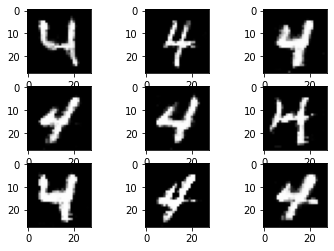

In [133]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(bagan_samples[i])
plt.show()

In [135]:
av_SSIM(bagan_samples)

0.33242153462871565

In [139]:
X_aug = X_train.copy()
y_aug = y_train.copy()
X_aug[left] = train_left
X_aug[to_replace] = bagan_samples

In [140]:
# model:
batch_size = 100
train_loader, val_loader = make_data_loaders(X_aug, y_aug, batch_size)
model = MnistResNet()

epochs = 5
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start_ts = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    train_res(epoch)
    
print(f"Training time: {time.time()-start_ts}s")


Epoch 1/5, training loss: 0.8178434393886063, validation loss: 0.2626412510871887
	     precision: 0.9257
	        recall: 0.9213
	            F1: 0.9173
	      accuracy: 0.9215



Epoch 2/5, training loss: 0.18198071491801077, validation loss: 0.2678670287132263
	     precision: 0.9302
	        recall: 0.9256
	            F1: 0.9221
	      accuracy: 0.9257



Epoch 3/5, training loss: 0.14343820840741198, validation loss: 0.21204149723052979
	     precision: 0.9444
	        recall: 0.9397
	            F1: 0.9373
	      accuracy: 0.9402



Epoch 4/5, training loss: 0.13255845791349807, validation loss: 0.18591541051864624
	     precision: 0.9531
	        recall: 0.9510
	            F1: 0.9488
	      accuracy: 0.9516



Epoch 5/5, training loss: 0.10166761519076924, validation loss: 0.14782817661762238
	     precision: 0.9613
	        recall: 0.9606
	            F1: 0.9579
	      accuracy: 0.9611
Training time: 609.1395840644836s


In [142]:
compute_test(model, test_loader, c)

test loss: 0.20848792791366577
	     precision: 0.9497
	        recall: 0.9469
	            F1: 0.9437
	      accuracy: 0.9475
accuracy for class 4: 0.8564154786150713
